# <center>Import</center>

In [1]:
import pandas as pd
import numpy as np
import csv
import time
import pickle
import copy
import math

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
# Make the graphs a bit prettier, and bigger
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# <center>Function definition</center>

In [2]:
def save_to_pickle_file(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_pickle_file(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# read solution
def read_solution(filename):
    with open(filename, 'r') as sol_file:
        reader = csv.reader(sol_file, delimiter=' ', skipinitialspace=True)
        cost_sol = []
        
        for row in reader:
            cost_sol.append(int(row[2]))
            
        return cost_sol

## <center>HW 1</center>

In [3]:
def bruteforce(n, M, pairs, print_out=True, repeat_num=1):
    keys = list(pairs.keys())
    max_num = 2**n - 1
    power2 = [2**x for x in range(n)]
    
    start_time = time.process_time()
    
    for j in range(repeat_num):
        best = -1
        max_cost = 0
        max_weight = M
        final_keys = []
        
        for i in range(1, max_num + 1):
            counter = 0
            cur_weight = 0
            cur_cost = 0
            used_keys = []

            for pow2 in power2:
                if pow2 & i:
                    used_keys.append(keys[counter])
                    cur_weight += int(keys[counter])
                    cur_cost += pairs[keys[counter]]

                counter += 1

            if cur_weight <= M and cur_cost > max_cost:
                best = i
                max_weight = cur_weight
                max_cost = cur_cost
                final_keys = used_keys
            
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'BRUTEFORCE', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', keys)
        print('final_keys:', final_keys)
        print('M:', M)
        print('max_weight:', max_weight)
        print('max_cost:', max_cost)
        print('best:', best)
    
    return (end_time - start_time) / repeat_num, max_cost

def fill_by(n, M, pairs, sorted_keys, sorted_by='cost', print_out=True, repeat_num=1):
    start_time = time.process_time()
    
    for i in range(repeat_num):
        max_cost = 0
        max_weight = 0
        final_keys = []
        
        for weight in sorted_keys:
            if max_weight + int(weight) > M:
                break

            max_weight += int(weight)
            max_cost += pairs[weight]
            final_keys.append(weight)
        
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'SORTED BY ' + sorted_by.upper() + 'S', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', sorted_keys)
        print('final_keys:', final_keys)
        print('M:', M)
        print('max_weight:', max_weight)
        print('max_cost:', max_cost)
    
    return (end_time - start_time) / repeat_num, max_cost

def measure_time(filename, solution_file, print_out=True, repeat_brute=1, repeat_other=1, no_brute=False):
    with open(filename, 'r') as inst_file:
        reader = csv.reader(inst_file, delimiter=' ', skipinitialspace=True)
        
        solution_list = read_solution(solution_file)

        bruteforce_time = []
        sorted_by_cost_time = []
        sorted_by_weight_time = []
        sorted_by_prop_time = []
        rel_err = {'prop': [], 'cost': [], 'weight': []}
        dupl_counter = 1
        dupl_counter_delta = 0.00001
        for row, solution in zip(reader, solution_list):
            n = int(row[1])
            M = int(row[2])

            pairs = {}
            proportion_pairs = {}
            for i in range(0, n*2 - 1, 2):
                if int(row[i + 3]) in pairs.keys():
                    # duplication found!
                    if print_out:
                        print(10*'-', 'File:', filename, 'row:', row[0], 'There is a duplicate key!', 10*'-')
                    
                    new_key = int(row[i + 3]) + dupl_counter*dupl_counter_delta
                    
                    dupl_counter += 1
                else:
                    new_key = int(row[i + 3])
                    
                # pair: weight - cost
                pairs[new_key] = int(row[i + 4])
                # used proportion: cost/weight
                proportion_pairs[new_key] = int(row[i + 4]) / int(row[i + 3])

            # descrnding order
            weights_by_cost = sorted(pairs, key=pairs.__getitem__, reverse=True)
            # ascending order
            weights_by_weight = [key for (key, value) in sorted(pairs.items())]
            # descending order
            weights_by_proportion = sorted(proportion_pairs, key=proportion_pairs.__getitem__, reverse=True)

            if no_brute is False:
                t, cost_brute = bruteforce(n, M, pairs, print_out, repeat_brute)
                bruteforce_time.append(t)
            
            t, cost_cost = fill_by(n, M, pairs, weights_by_cost, 'cost', print_out, repeat_other)
            sorted_by_cost_time.append(t)
            
            t, cost_weight = fill_by(n, M, pairs, weights_by_weight, 'weight', print_out, repeat_other)
            sorted_by_weight_time.append(t)
            
            t, cost_prop = fill_by(n, M, pairs, weights_by_proportion, 'proportion', print_out, repeat_other)
            sorted_by_prop_time.append(t)

            rel_err['cost'].append((solution - cost_cost) / solution)
            rel_err['weight'].append((solution - cost_weight) / solution)
            rel_err['prop'].append((solution - cost_prop) / solution)

    return bruteforce_time, sorted_by_cost_time, sorted_by_weight_time, sorted_by_prop_time, rel_err

## <center>HW 2 and HW 3</center>

In [16]:
best_weight = 0
best_cost = 0

def start_branch_and_bound(M, pairs, repeat_num=1, print_out=True):
    global best_weight
    global best_cost
    keys = list(pairs.keys())
        
    start_time = time.process_time()
    
    for i in range(repeat_num):
        best_weight = 0
        best_cost = 0
        
        branch_and_bound(M, pairs, keys, 1, 0, 0, 0)
        branch_and_bound(M, pairs, keys, 0, 0, 0, 0)
        
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'BRANCH AND BOUND', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', pairs.keys())
        print('M:', M)
        print('max_weight:', best_weight)
        print('max_cost:', best_cost)
    
    return (end_time - start_time) / repeat_num, best_cost


def branch_and_bound(M, pairs, keys, flag, cur_weight, cur_cost, key_index):
    if key_index >= len(pairs):
        return
    
    global best_weight
    global best_cost
    
    if sum([pairs[x] for x in keys[key_index:]]) + cur_cost < best_cost:
        return
    
    if flag == 1:
        node_weight = int(keys[key_index])
        node_cost = pairs[keys[key_index]]
        
        if cur_weight + node_weight > M:
            return
        
        node_weight += cur_weight
        node_cost += cur_cost
        
        if node_cost > best_cost:
            best_cost = node_cost
            best_weight = node_weight
    else:
        node_weight = cur_weight
        node_cost = cur_cost
        
    # left subtree
    branch_and_bound(M, pairs, keys, 1, node_weight, node_cost, key_index + 1)
    # right subtree
    branch_and_bound(M, pairs, keys, 0, node_weight, node_cost, key_index + 1)
    
    
def fptas(n, M, pairs, eps, repeat_num=1, print_out=True):
    c_max = max(pairs.values())
    K = eps * c_max / n
    
    new_pairs = copy.deepcopy(pairs)
    for key in new_pairs:
        new_pairs[key] = int(pairs[key] / K)
        
    if print_out:
        print('fptas pairs:', new_pairs)
    
    t, max_cost = dyn_cost_decompos(n, M, new_pairs, repeat_num=repeat_num, print_out=print_out)
    
    if print_out:
        print('fptas max_cost in origin coords:', math.ceil(max_cost * K))
    
    return t, math.ceil(max_cost * K)
    
def dyn_cost_decompos(N, M, pairs, repeat_num=1, print_out=True):
    keys = list(pairs.keys())
    cost_sum = sum(pairs.values())
    
    start_time = time.process_time()
    
    for r in range(repeat_num):
        # create table (n+1)*(sum(Cost)+1)
        wtab = np.zeros((N + 1, cost_sum + 1))
        # W(0,c) = inf for all c > 0 
        wtab[0,:] = np.inf
        # W(0,0) = 0
        wtab[0, 0] = 0

        # W(i+1, c) = min(W(i, c), W(i, c-ci+1)+wi+1) for all i > 0
        for c in range(1, cost_sum + 1):
            for n in range(1, N + 1):
                cur_weight = int(keys[n-1])
                cur_cost = pairs[keys[n-1]]

                if c - cur_cost < 0:
                    wtab[n, c] = min(wtab[n-1, c], np.inf)
                else:
                    wtab[n, c] = min(wtab[n-1, c], wtab[n-1, c-cur_cost] + cur_weight)

        max_cost = 0
        max_weight = 0
        for i in range(cost_sum, 0, -1):
            if wtab[N, i] <= M:
                max_weight = wtab[N, i]
                max_cost = i
                break
                
    end_time = time.process_time()
    
    if print_out:
        print(max_weight, max_cost)
#         print(wtab.T)

    return (end_time - start_time) / repeat_num, max_cost
    

def measure_time2(filename, solution_file, print_out=True, repeat_bab=1, repeat_other=1):
    with open(filename, 'r') as inst_file:
        reader = csv.reader(inst_file, delimiter=' ', skipinitialspace=True)
        
        solution_list = read_solution(solution_file)

        bab_time = []
        dynam_time = []
        fptas_time = [list() for x in range(3)]
        rel_err = {'eps1': [], 'eps2': [], 'eps3': []}
        dupl_counter = 1
        dupl_counter_delta = 0.00001
        for row, solution in zip(reader, solution_list):
            n = int(row[1])
            M = int(row[2])

            pairs = {}
            for i in range(0, n*2 - 1, 2):
                if int(row[i + 3]) in pairs.keys():
                    # duplication found!
                    if print_out:
                        print(10*'-', 'File:', filename, 'row:', row[0], 'There is a duplicate key!', 10*'-')
                    
                    new_key = int(row[i + 3]) + dupl_counter*dupl_counter_delta
                    
                    dupl_counter += 1
                else:
                    new_key = int(row[i + 3])
                    
                # pair: weight - cost
                pairs[new_key] = int(row[i + 4])

            # branch and bound algorithm
            t, bab_cost = start_branch_and_bound(M, pairs, repeat_bab, print_out)
            bab_time.append(t)
            
            # dynamic algorithm: decomposition by cost
            t, dynam_cost = dyn_cost_decompos(n, M, pairs, repeat_other, print_out)
            dynam_time.append(t)
            
            eps_list = [0.001, 0.01, 0.05]
            for eps, i in zip(eps_list, range(len(eps_list))):
                t, fptas_cost = fptas(n, M, pairs, eps, repeat_other, print_out)
                fptas_time[i].append(t)

                tmp_key = 'eps' + str(i + 1)
                rel_err[tmp_key].append(abs(solution - fptas_cost) / solution)
            
            
            
    return bab_time, dynam_time, fptas_time, rel_err


# this function uses other functions defined in HW 2
def measure_time3(filename, print_out=True, repeat_bab=1, repeat_other=1):
#     print(filename)
    with open(filename, 'r') as inst_file:
        reader = csv.reader(inst_file, delimiter=' ', skipinitialspace=True)
        
        bab_time = []
        dynam_time = []
        sorted_by_prop_time = []
        rel_err = {'prop': []}
        dupl_counter = 1
        dupl_counter_delta = 0.00001
        for row in reader:
            n = int(row[1])
            M = int(row[2])

            pairs = {}
            proportion_pairs = {}
            for i in range(0, n*2 - 1, 2):
                if int(row[i + 3]) in pairs.keys():
                    # duplication found!
                    if print_out:
                        print(10*'-', 'File:', filename, 'row:', row[0], 'There is a duplicate key!', 10*'-')
                    
                    new_key = int(row[i + 3]) + dupl_counter*dupl_counter_delta
                    
                    dupl_counter += 1
                else:
                    new_key = int(row[i + 3])
                    
                # pair: weight - cost
                pairs[new_key] = int(row[i + 4])
                # used proportion: cost/weight
                proportion_pairs[new_key] = int(row[i + 4]) / int(row[i + 3])

            # descending order
            weights_by_proportion = sorted(proportion_pairs, key=proportion_pairs.__getitem__, reverse=True)

            # branch and bound algorithm
            t, bab_cost = start_branch_and_bound(M, pairs, repeat_bab, print_out)
            bab_time.append(t)
            
            # dynamic algorithm: decomposition by cost
            t, dynam_cost = dyn_cost_decompos(n, M, pairs, repeat_other, print_out)
            dynam_time.append(t)
            
            t, cost_prop = fill_by(n, M, pairs, weights_by_proportion, 'proportion', print_out, repeat_other)
            sorted_by_prop_time.append(t)

            if bab_cost == 0:
#                 print(row)
                rel_err['prop'].append(0)
            else:               
                rel_err['prop'].append((bab_cost - cost_prop) / bab_cost)
            
    return bab_time, dynam_time, sorted_by_prop_time, rel_err


# <center>Computation</center>

### Define file for saving/loading data

In [5]:
# save or load data to/from this file
result_file = 'result'
result_file2 = 'result2'
result_file3 = 'result3'

## <center>HW 1</center>

### Load previously computed results from a file

In [12]:
# load computed results from the file
dictn = load_pickle_file(result_file)

### Or run a new computation

You must run the cell below some times with different inputs (primarily from n=25 and to the end with *no_brute=True* option)

In [97]:
# n_list = [4,10,15,20,22,25,27,30,32,35,37,40]
n_list = [25,27,30,32,35,37,40]

# repeat_brute = [1000,10] + (len(n_list) - 2)*[1]
repeat_brute = 1
repeat_other = 15000

file_inst_template = './data/inst/knap_{}.inst.dat'
file_sol_template = './data/sol/knap_{}.sol.dat'
dictn = {}
# dictn = load_pickle_file(result_file)
    
# for n, rep_brute in zip(n_list, repeat_brute):
for n in n_list:
    dictn[n] = list(measure_time(
                    file_inst_template.format(n), file_sol_template.format(n), print_out=False, 
                    repeat_brute=repeat_brute, repeat_other=repeat_other,
#                     repeat_brute=rep_brute, repeat_other=repeat_other,
                    no_brute=True)
                   )

### Smart way to get asymptotic equal time of bruteforce algorithm

In [203]:
index = 22

for brute_time in dictn[index][0]:
    for n in n_list:
        dictn[n][0].append(brute_time * 2**(n - index))

save_to_pickle_file(dictn, result_file)

### Save computed results

In [206]:
save_to_pickle_file(dictn, result_file)

## <center>HW 2</center>

### Load previously computed results from a file

In [13]:
# load computed results from the file
dictn2 = load_pickle_file(result_file2)

### Or run a new computation

In [54]:
# n_list = [4,10,15,20,22,25,27,30,32,35,37,40]
n_list = [4]

repeat_bab = 1
repeat_other = 1

file_inst_template = './data/inst/knap_{}.inst.dat'
file_sol_template = './data/sol/knap_{}.sol.dat'
# dictn2 = {}
    
for n in n_list:
    dictn2[n] = list(measure_time2(
                     file_inst_template.format(n), file_sol_template.format(n), 
                     print_out=False, repeat_bab=repeat_bab, repeat_other=repeat_other)
                   )

### Save computed results

In [204]:
save_to_pickle_file(dictn2, result_file2)

## <center>HW 3</center>

### Load previously computed results from a file

In [12]:
# load computed results from the file
dictn3 = load_pickle_file(result_file3)

### Or run a new computation

In [61]:
config_type = ['max_cost', 'max_weight', 'ratio', 'exponent']

# general parameters for knap generator
n = 4
N = 5
m = 0.5
w = 100
c = 250
k = 1
d = 0

max_cost_range = range(50, 501, 50)
max_weight_range = range(20, 201, 20)
m_test_range = [x/10 for x in range(1,10)]
k_test_range = range(1, 10)

repeat_bab = 1
repeat_other = 1

# file_inst_template = './data/my_inst/knap_{}.inst.dat'
file_inst_template = './data/my_inst/knap_{}_{}_{}_{}_{}_{}.txt'
dictn3 = {}
    
for key in config_type:
    dictn3[key] = []

# read files with tested cost
for cost in max_cost_range:
    dictn3['max_cost'].append(list(measure_time3(
            file_inst_template.format(n, m, w, cost, k, d), print_out=False,
            repeat_bab=repeat_bab, repeat_other=repeat_other)
            ))
    
# read files with tested weight
for weight in max_weight_range:
    dictn3['max_weight'].append(list(measure_time3(
            file_inst_template.format(n, m, weight, c, k, d), print_out=False,
            repeat_bab=repeat_bab, repeat_other=repeat_other)
            ))
    
# read files with tested proportion (bag size to overall weight)
for m_test in m_test_range:
    dictn3['ratio'].append(list(measure_time3(
            file_inst_template.format(n, m_test, w, c, k, d), print_out=False,
            repeat_bab=repeat_bab, repeat_other=repeat_other)
            ))
    
# read files with tested k-value
for k_test in k_test_range:
    dictn3['exponent'].append(list(measure_time3(
            file_inst_template.format(n, m, w, c, k_test, d), print_out=False,
            repeat_bab=repeat_bab, repeat_other=repeat_other)
            ))

### Save computed results

In [45]:
save_to_pickle_file(dictn3, result_file3)

# <center>Plots</center>

## <center>Data preparation</center>

### HW 1

In [56]:
# compute average and max values
dictn_mean = load_pickle_file(result_file)
col_num = len(dictn_mean[4])


for key in dictn_mean:
    # for every n
    for i in range(col_num):
        # for each column
        if i < col_num - 1:
            dictn_mean[key][i] = np.mean(dictn_mean[key][i], dtype='float64')
        else:
            dictn_mean[key][i]['max_cost_err'] = max(dictn_mean[key][i]['cost'])
            dictn_mean[key][i]['max_weight_err'] = max(dictn_mean[key][i]['weight'])
            dictn_mean[key][i]['max_prop_err'] = max(dictn_mean[key][i]['prop'])
            
            
            dictn_mean[key][i]['avg_cost_err'] = np.mean(dictn_mean[key][i]['cost'], dtype='float64')
            dictn_mean[key][i]['avg_weight_err'] = np.mean(dictn_mean[key][i]['weight'], dtype='float64')
            dictn_mean[key][i]['avg_prop_err'] = np.mean(dictn_mean[key][i]['prop'], dtype='float64')

In [57]:
n_list = [4,10,15,20,22,25,27,30,32,35,37,40]
avg_brute_time = []
avg_by_cost_time = []
avg_by_weight_time = []
avg_by_prop_time = []

max_by_cost_error = []
max_by_weight_error = []
max_by_prop_error = []

avg_by_cost_error = []
avg_by_weight_error = []
avg_by_prop_error = []

for n in n_list:
    avg_brute_time.append(dictn_mean[n][0])
    avg_by_cost_time.append(dictn_mean[n][1])
    avg_by_weight_time.append(dictn_mean[n][2])
    avg_by_prop_time.append(dictn_mean[n][3])
    
    max_by_cost_error.append(dictn_mean[n][4]['max_cost_err'])
    max_by_weight_error.append(dictn_mean[n][4]['max_weight_err'])
    max_by_prop_error.append(dictn_mean[n][4]['max_prop_err'])
    
    avg_by_cost_error.append(dictn_mean[n][4]['avg_cost_err'])
    avg_by_weight_error.append(dictn_mean[n][4]['avg_weight_err'])
    avg_by_prop_error.append(dictn_mean[n][4]['avg_prop_err'])

### HW 2

In [109]:
# compute average and max values
dictn_mean2 = load_pickle_file(result_file2)
col_num = len(dictn_mean2[4])


for key in dictn_mean2:
    for i in range(col_num):
        if i < col_num - 2:
            # B&B and dynamic programming
            dictn_mean2[key][i] = np.mean(dictn_mean2[key][i], dtype='float64')
        elif i == col_num - 2:
            # fptas time for eps = [0.001, 0.01, 0.05]
            dictn_mean2[key][i][0] = np.mean(dictn_mean2[key][i][0], dtype='float64')
            dictn_mean2[key][i][1] = np.mean(dictn_mean2[key][i][1], dtype='float64')
            dictn_mean2[key][i][2] = np.mean(dictn_mean2[key][i][2], dtype='float64')
        else:
            # fptas error for eps = [0.001, 0.01, 0.05]
            dictn_mean2[key][i]['max_fptas_err_1'] = max(dictn_mean2[key][i]['eps1'])
            dictn_mean2[key][i]['max_fptas_err_2'] = max(dictn_mean2[key][i]['eps2'])
            dictn_mean2[key][i]['max_fptas_err_3'] = max(dictn_mean2[key][i]['eps3'])
            
            
            dictn_mean2[key][i]['avg_fptas_err_1'] = np.mean(dictn_mean2[key][i]['eps1'], dtype='float64')
            dictn_mean2[key][i]['avg_fptas_err_2'] = np.mean(dictn_mean2[key][i]['eps2'], dtype='float64')
            dictn_mean2[key][i]['avg_fptas_err_3'] = np.mean(dictn_mean2[key][i]['eps3'], dtype='float64')

In [111]:
n_list_2 = [4,10,15,20,22,25,27,30,32]
avg_bab_time = []
avg_dynam_time = []
avg_fptas_time_1 = []
avg_fptas_time_2 = []
avg_fptas_time_3 = []

max_fptas_err_1 = []
max_fptas_err_2 = []
max_fptas_err_3 = []

avg_fptas_err_1 = []
avg_fptas_err_2 = []
avg_fptas_err_3 = []

for n in n_list_2:
    avg_bab_time.append(dictn_mean2[n][0])
    avg_dynam_time.append(dictn_mean2[n][1])
    avg_fptas_time_1.append(dictn_mean2[n][2][0])
    avg_fptas_time_2.append(dictn_mean2[n][2][1])
    avg_fptas_time_3.append(dictn_mean2[n][2][2])
    
    max_fptas_err_1.append(dictn_mean2[n][3]['max_fptas_err_1'])
    max_fptas_err_2.append(dictn_mean2[n][3]['max_fptas_err_2'])
    max_fptas_err_3.append(dictn_mean2[n][3]['max_fptas_err_3'])
    
    avg_fptas_err_1.append(dictn_mean2[n][3]['avg_fptas_err_1'])
    avg_fptas_err_2.append(dictn_mean2[n][3]['avg_fptas_err_2'])
    avg_fptas_err_3.append(dictn_mean2[n][3]['avg_fptas_err_3'])

### HW 3

In [78]:
# compute average and max values
dictn_mean3 = load_pickle_file(result_file3)
n = len(dictn_mean3['max_cost'][0][0])
col_num = len(dictn_mean3['max_cost'][0])

# initialize dictionary for different tests
avg_bab3_time = {}
avg_dynam3_time = {}
avg_prop3_time = {}

max_prop3_error = {}
avg_prop3_error = {}

# get amount of files (e.g. different configurations) for each test type
# and create dictionaries of results (as list)
config_size = []
for key in config_type:
    config_size.append(len(dictn_mean3[key]))
    
    avg_bab3_time[key] = []
    avg_dynam3_time[key] = []
    avg_prop3_time[key] = []

    max_prop3_error[key] = []
    avg_prop3_error[key] = []
    
for key, size in zip(config_type, config_size):
    for conf in range(size):
        for i in range(col_num):
            # for each column
            if i < col_num - 1:
                dictn_mean3[key][conf][i] = np.mean(dictn_mean3[key][conf][i], dtype='float64')
            else:
                dictn_mean3[key][conf][i]['max_err'] = max(dictn_mean3[key][conf][i]['prop'])
                dictn_mean3[key][conf][i]['avg_err'] = np.mean(dictn_mean3[key][conf][i]['prop'], dtype='float64')

for key, size in zip(config_type, config_size):
    for conf in range(size):
        avg_bab3_time[key].append(dictn_mean3[key][conf][0])
        avg_dynam3_time[key].append(dictn_mean3[key][conf][1])
        avg_prop3_time[key].append(dictn_mean3[key][conf][2])

        max_prop3_error[key].append(dictn_mean3[key][conf][3]['max_err'])
        avg_prop3_error[key].append(dictn_mean3[key][conf][3]['avg_err'])


## <center>Plotting</center>

### HW 1

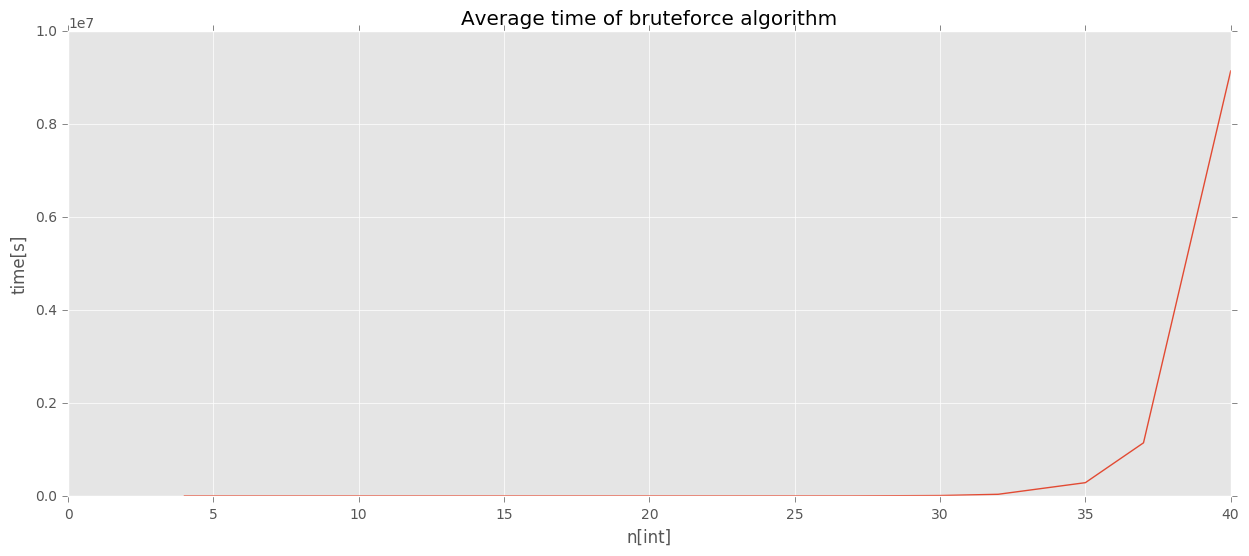

In [8]:
plt.plot(n_list, avg_brute_time)
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.title('Average time of bruteforce algorithm')

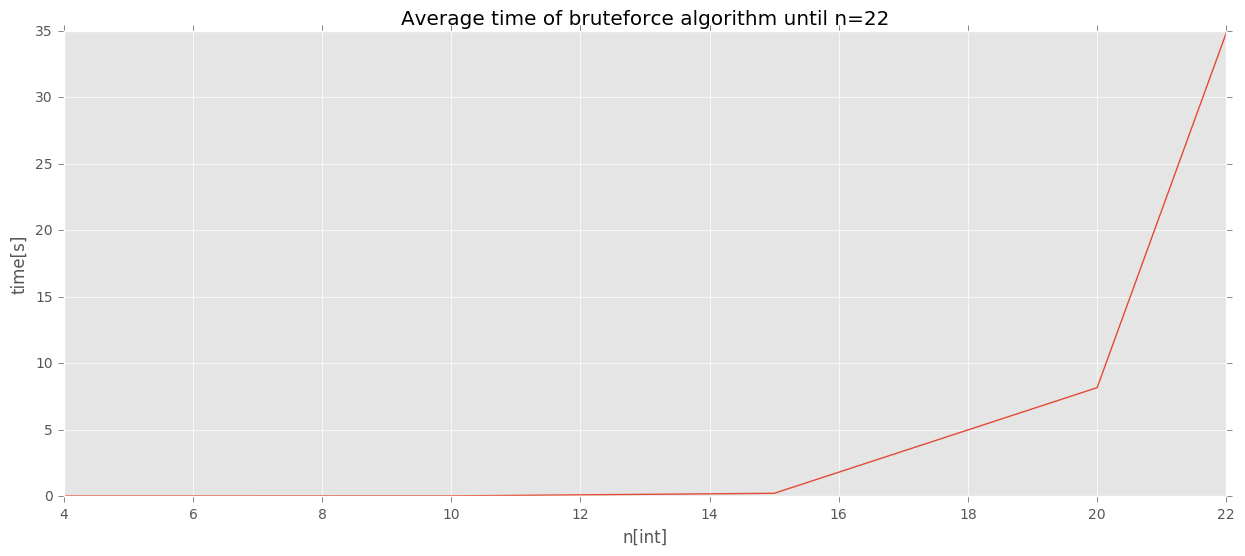

In [19]:
plt.plot(n_list[:5], avg_brute_time[:5])
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.title('Average time of bruteforce algorithm until n=22')

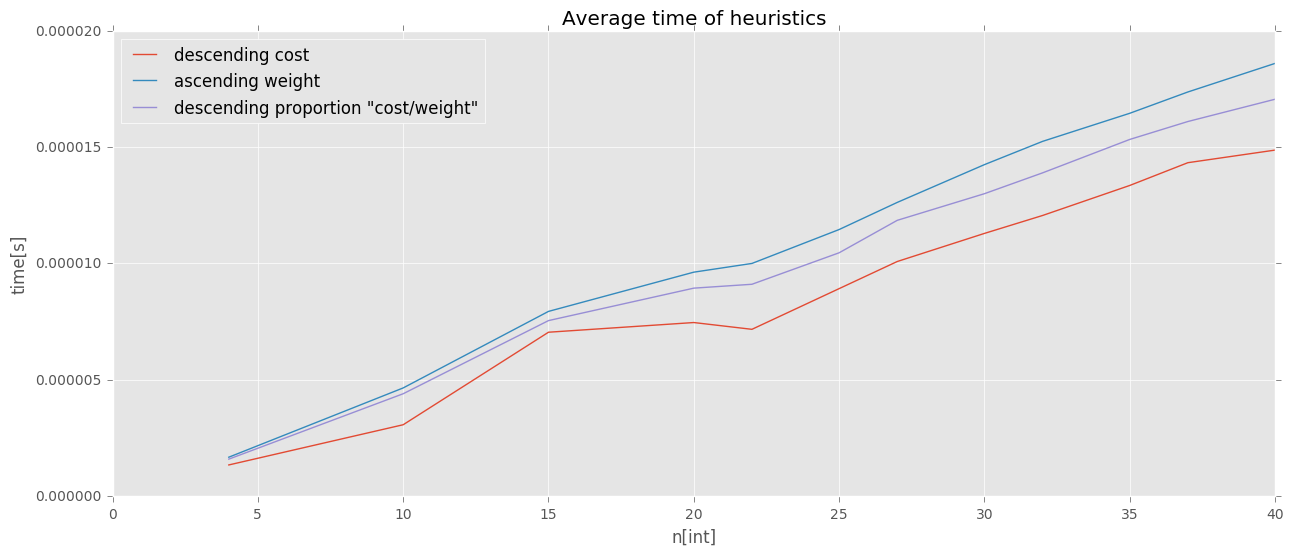

In [9]:
plt.plot(n_list, avg_by_cost_time, label='descending cost')
plt.plot(n_list, avg_by_weight_time, label='ascending weight')
plt.plot(n_list, avg_by_prop_time, label='descending proportion "cost/weight"')
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Average time of heuristics')

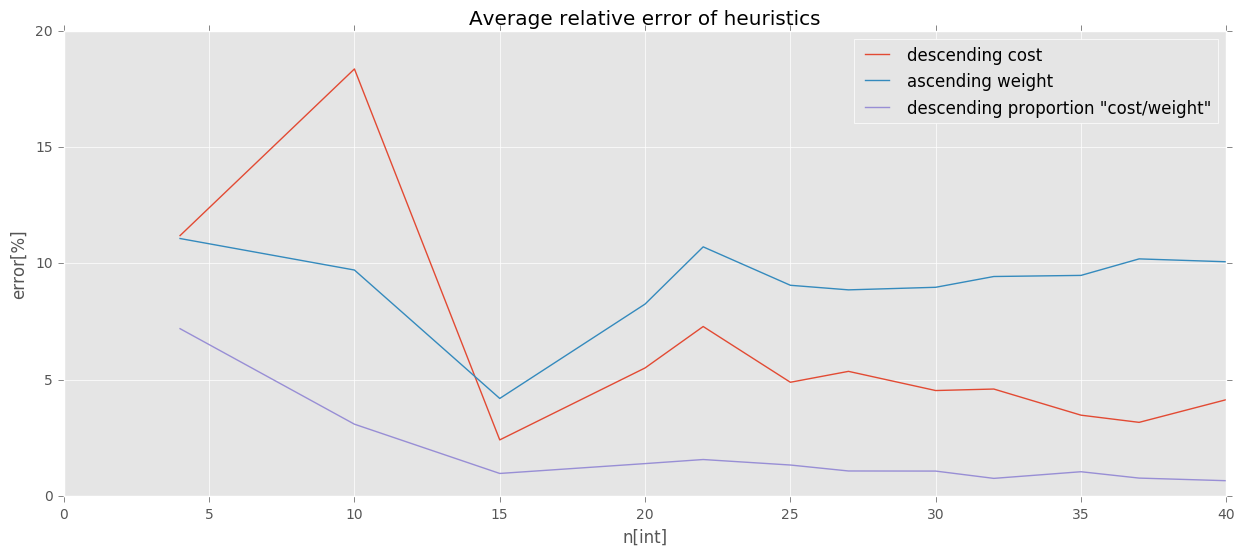

In [10]:
plt.plot(n_list, [x*100 for x in avg_by_cost_error], label='descending cost')
plt.plot(n_list, [x*100 for x in avg_by_weight_error], label='ascending weight')
plt.plot(n_list, [x*100 for x in avg_by_prop_error], label='descending proportion "cost/weight"')
plt.xlabel('n[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Average relative error of heuristics')

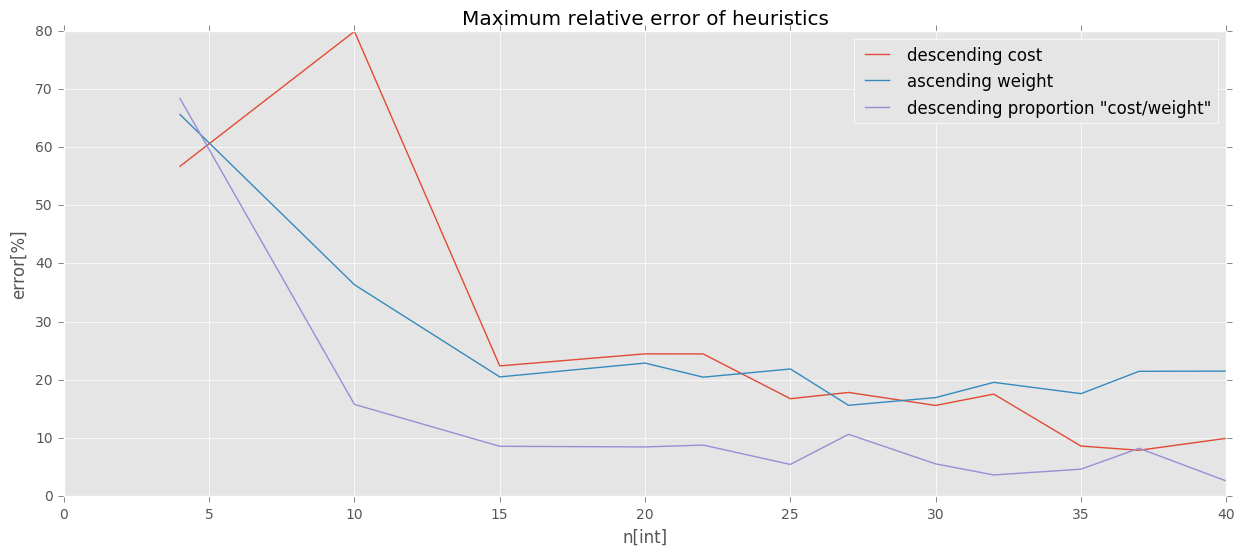

In [11]:
plt.plot(n_list, [x*100 for x in max_by_cost_error], label='descending cost')
plt.plot(n_list, [x*100 for x in max_by_weight_error], label='ascending weight')
plt.plot(n_list, [x*100 for x in max_by_prop_error], label='descending proportion "cost/weight"')
plt.xlabel('n[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Maximum relative error of heuristics')

### HW 2

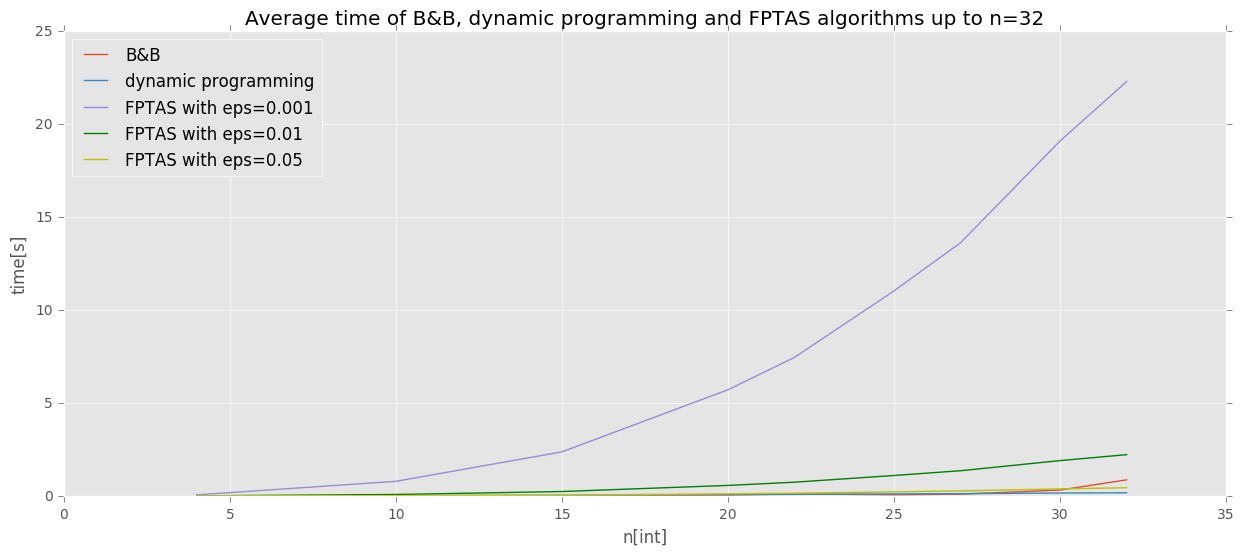

In [117]:
plt.plot(n_list_2, avg_bab_time, label='B&B')
plt.plot(n_list_2, avg_dynam_time, label='dynamic programming')
plt.plot(n_list_2, avg_fptas_time_1, label='FPTAS with eps=0.001')
plt.plot(n_list_2, avg_fptas_time_2, 'g', label='FPTAS with eps=0.01')
plt.plot(n_list_2, avg_fptas_time_3, 'y', label='FPTAS with eps=0.05')
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Average time of B&B, dynamic programming and FPTAS algorithms up to n=32')

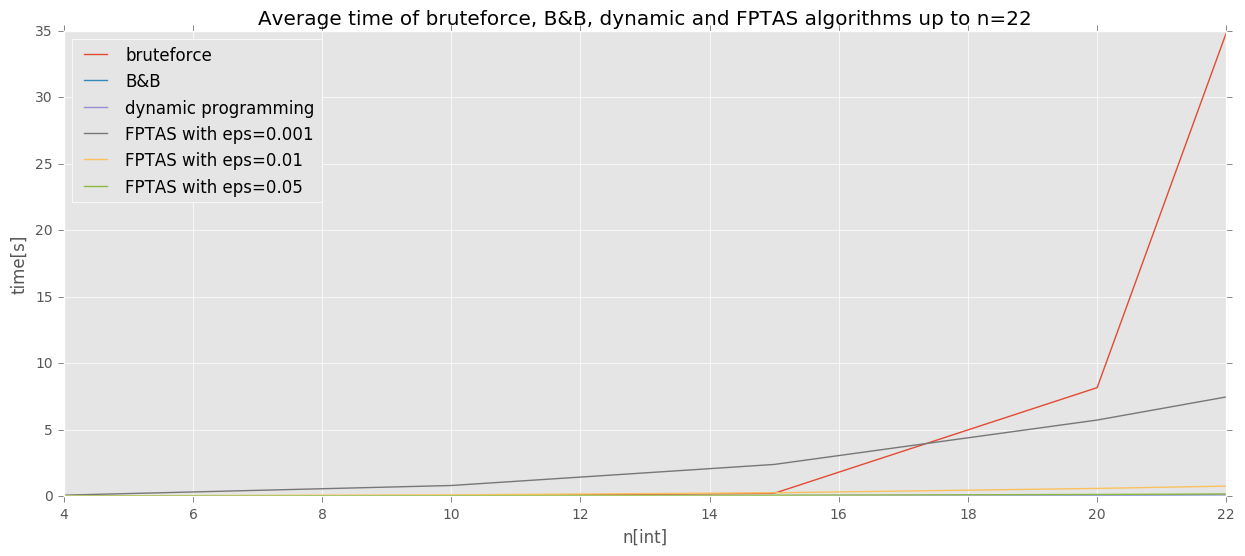

In [116]:
plt.plot(n_list_2[:5], avg_brute_time[:5], label='bruteforce')
plt.plot(n_list_2[:5], avg_bab_time[:5], label='B&B')
plt.plot(n_list_2[:5], avg_dynam_time[:5], label='dynamic programming')
plt.plot(n_list_2[:5], avg_fptas_time_1[:5], label='FPTAS with eps=0.001')
plt.plot(n_list_2[:5], avg_fptas_time_2[:5], label='FPTAS with eps=0.01')
plt.plot(n_list_2[:5], avg_fptas_time_3[:5], label='FPTAS with eps=0.05')
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Average time of bruteforce, B&B, dynamic and FPTAS algorithms up to n=22')

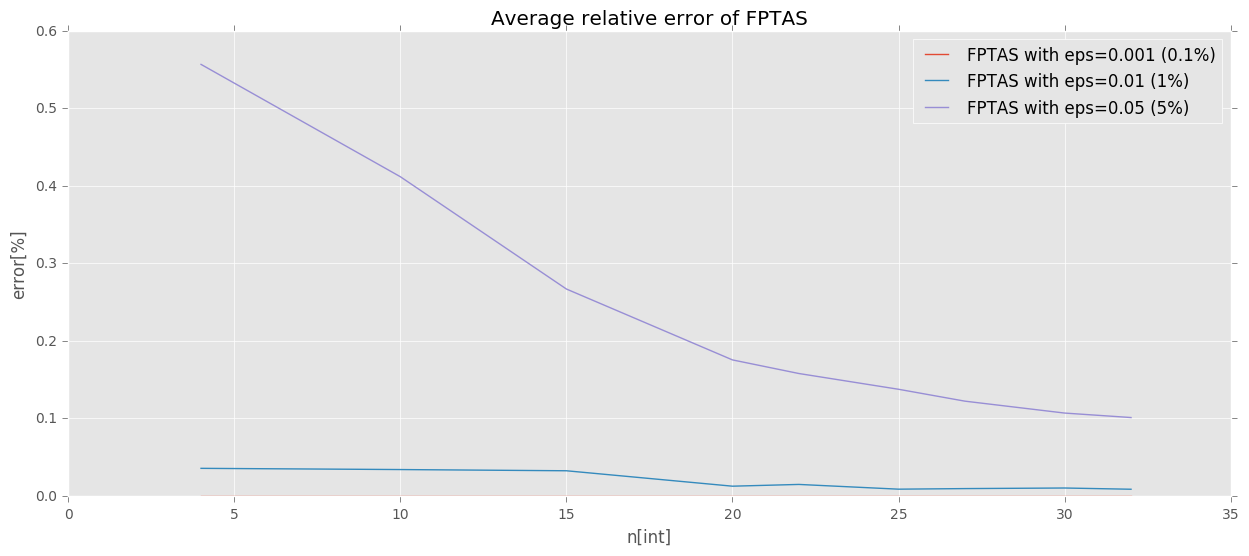

In [114]:
plt.plot(n_list_2, [x*100 for x in avg_fptas_err_1], label='FPTAS with eps=0.001 (0.1%)')
plt.plot(n_list_2, [x*100 for x in avg_fptas_err_2], label='FPTAS with eps=0.01 (1%)')
plt.plot(n_list_2, [x*100 for x in avg_fptas_err_3], label='FPTAS with eps=0.05 (5%)')
plt.xlabel('n[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Average relative error of FPTAS')

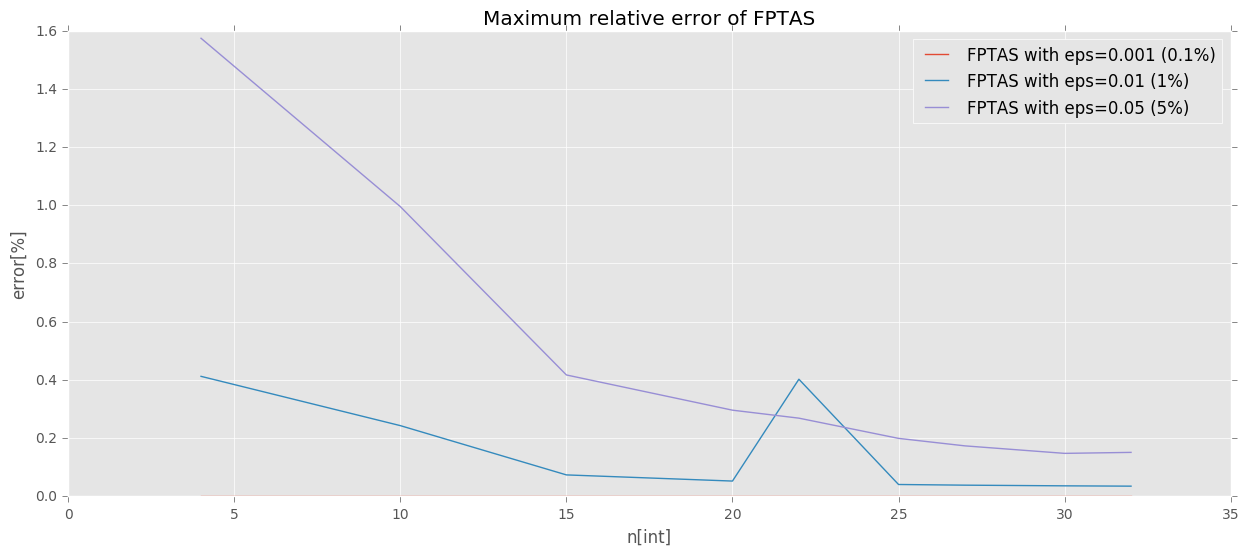

In [115]:
plt.plot(n_list_2, [x*100 for x in max_fptas_err_1], label='FPTAS with eps=0.001 (0.1%)')
plt.plot(n_list_2, [x*100 for x in max_fptas_err_2], label='FPTAS with eps=0.01 (1%)')
plt.plot(n_list_2, [x*100 for x in max_fptas_err_3], label='FPTAS with eps=0.05 (5%)')
plt.xlabel('n[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Maximum relative error of FPTAS')

### HW 3

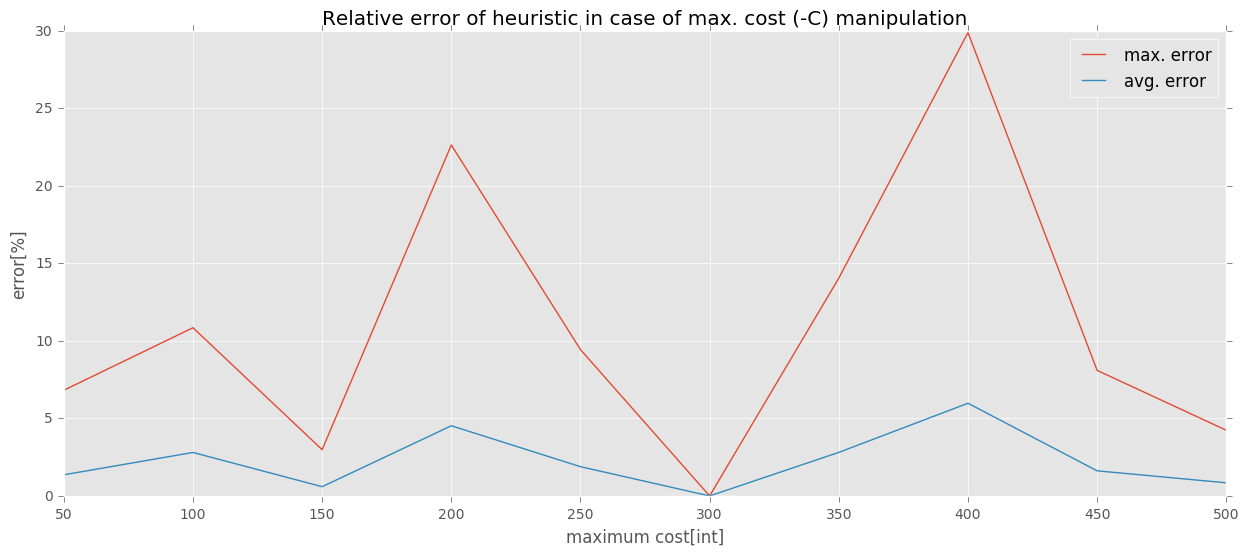

In [106]:
plt.plot(max_cost_range, [x*100 for x in max_prop3_error['max_cost']], label='max. error')
plt.plot(max_cost_range, [x*100 for x in avg_prop3_error['max_cost']], label='avg. error')
plt.xlabel('maximum cost[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Relative error of heuristic in case of max. cost manipulation')

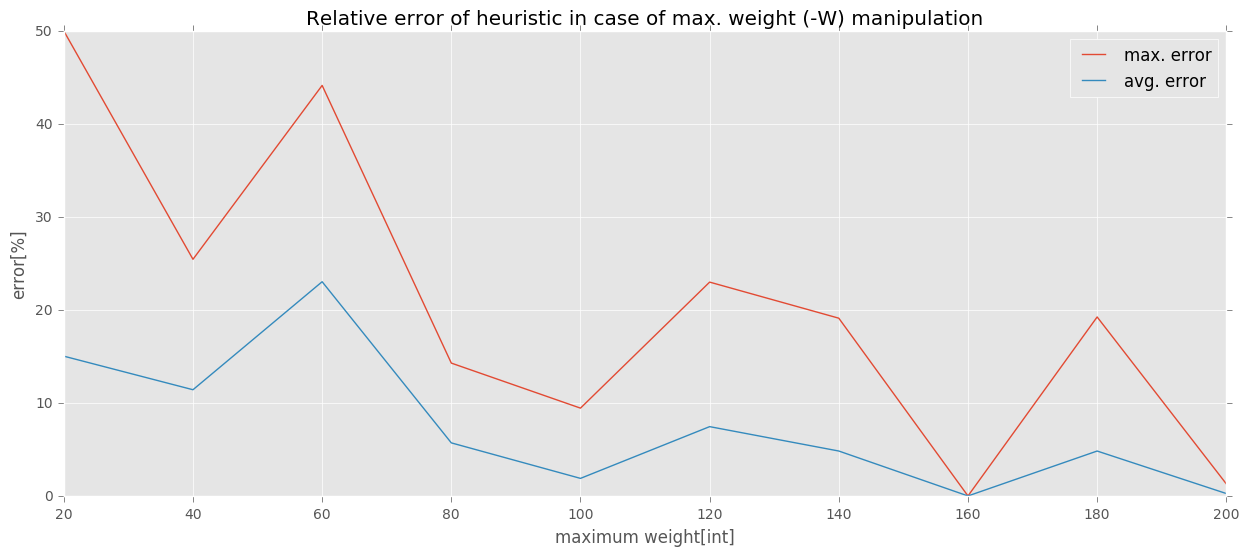

In [104]:
plt.plot(max_weight_range, [x*100 for x in max_prop3_error['max_weight']], label='max. error')
plt.plot(max_weight_range, [x*100 for x in avg_prop3_error['max_weight']], label='avg. error')
plt.xlabel('maximum weight[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Relative error of heuristic in case of max. weight manipulation')

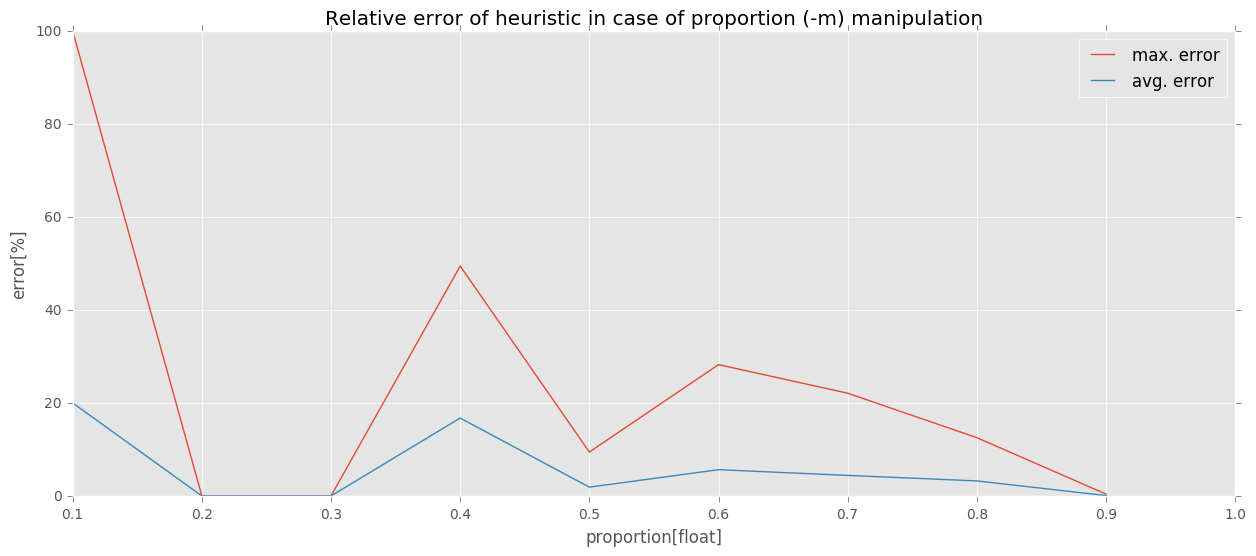

In [103]:
plt.plot(m_test_range, [x*100 for x in max_prop3_error['ratio']], label='max. error')
plt.plot(m_test_range, [x*100 for x in avg_prop3_error['ratio']], label='avg. error')
plt.xlabel('ratio m[float]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Relative error of heuristic in case of ratio "m" manipulation')

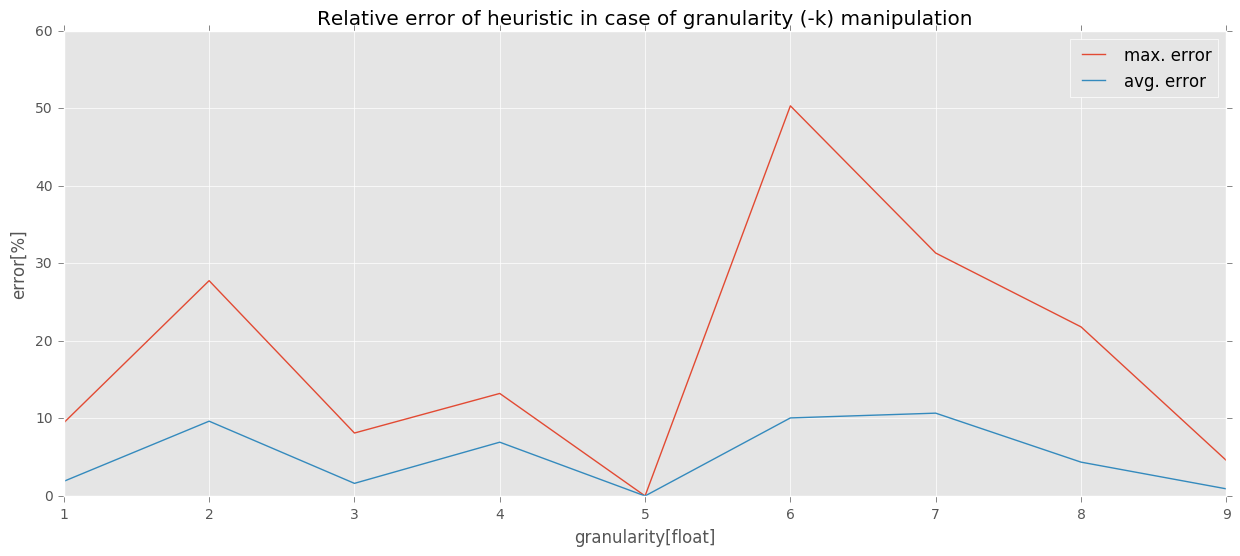

In [105]:
plt.plot(k_test_range, [x*100 for x in max_prop3_error['exponent']], label='max. error')
plt.plot(k_test_range, [x*100 for x in avg_prop3_error['exponent']], label='avg. error')
plt.xlabel('exponent k[float]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Relative error of heuristic in case of granularity exponent manipulation')

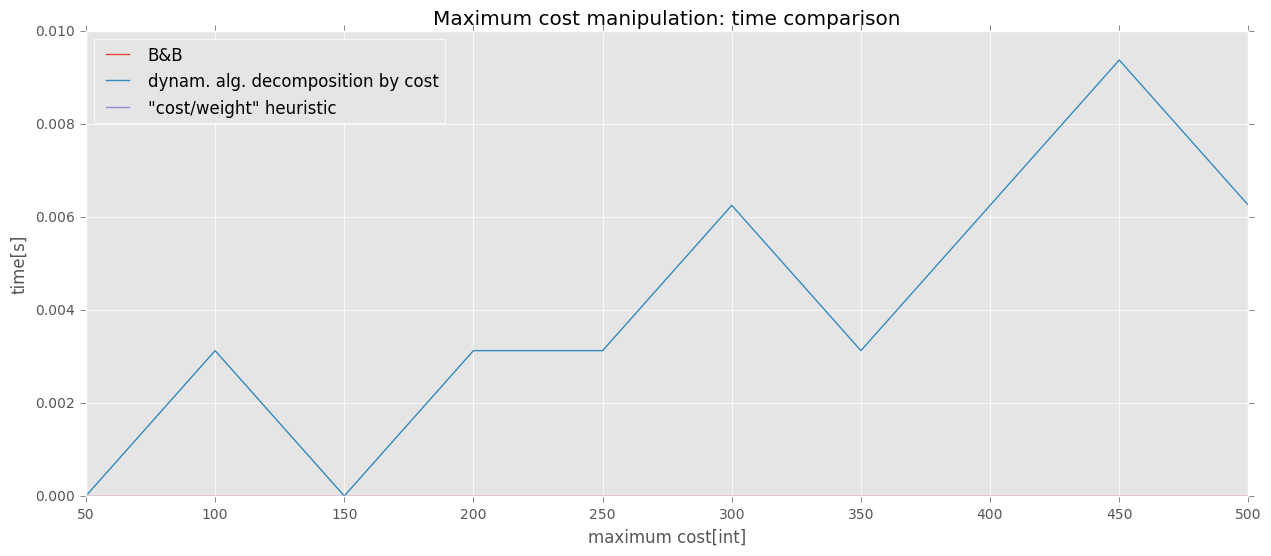

In [107]:
plt.plot(max_cost_range, avg_bab3_time['max_cost'], label='B&B')
plt.plot(max_cost_range, avg_dynam3_time['max_cost'], label='dynam. alg. decomposition by cost')
plt.plot(max_cost_range, avg_prop3_time['max_cost'], label='"cost/weight" heuristic')
plt.xlabel('maximum cost[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Maximum cost manipulation: time comparison')

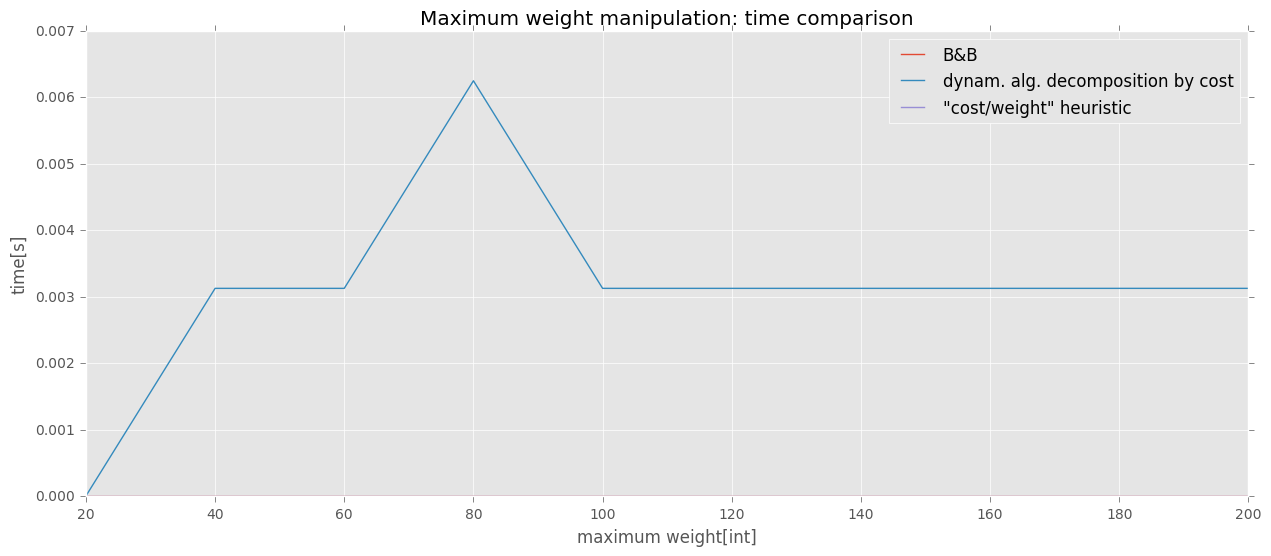

In [108]:
plt.plot(max_weight_range, avg_bab3_time['max_weight'], label='B&B')
plt.plot(max_weight_range, avg_dynam3_time['max_weight'], label='dynam. alg. decomposition by cost')
plt.plot(max_weight_range, avg_prop3_time['max_weight'], label='"cost/weight" heuristic')
plt.xlabel('maximum weight[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Maximum weight manipulation: time comparison')

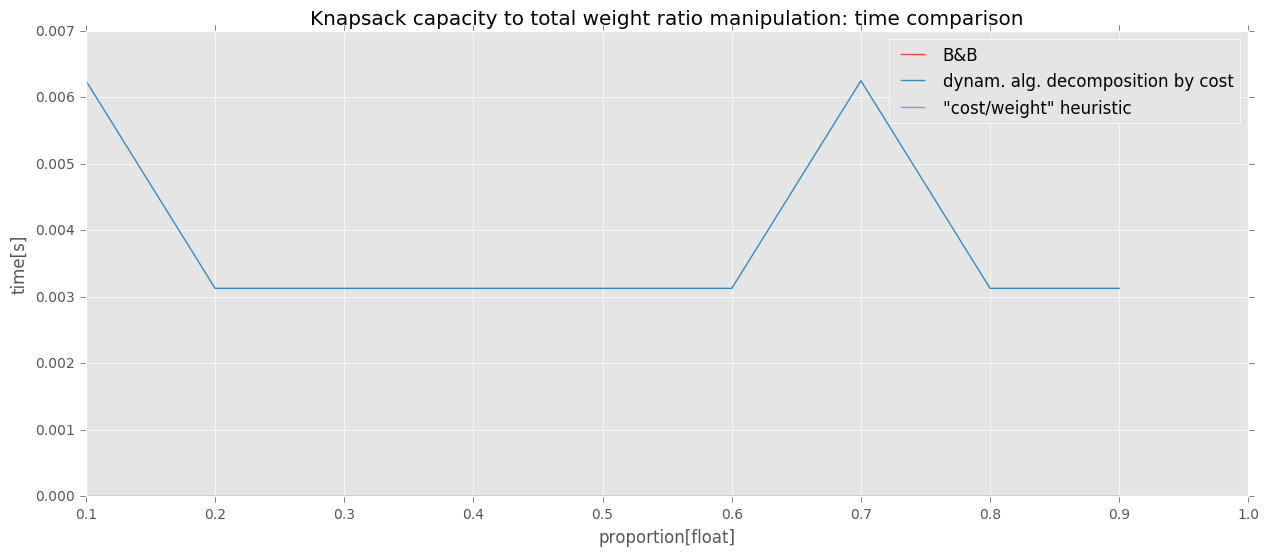

In [109]:
plt.plot(m_test_range, avg_bab3_time['ratio'], label='B&B')
plt.plot(m_test_range, avg_dynam3_time['ratio'], label='dynam. alg. decomposition by cost')
plt.plot(m_test_range, avg_prop3_time['ratio'], label='"cost/weight" heuristic')
plt.xlabel('ratio m[float]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Knapsack capacity to total weight ratio manipulation: time comparison')

In [ ]:
plt.plot(k_test_range, avg_bab3_time['exponent'], label='B&B')
plt.plot(k_test_range, avg_dynam3_time['exponent'], label='dynam. alg. decomposition by cost')
plt.plot(k_test_range, avg_prop3_time['exponent'], label='"cost/weight" heuristic')
plt.xlabel('exponent[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Granularity exponent manipulation: time comparison')